# Etiquetado de los datos versión 2
---

En esta ocasión, exploraremos el índice de abandono de los alumnos considerando si entregaron el proyecto de programación de la asignatura. 

Para ello, seguiremos los siguientes pasos: 

- Obtener las tareas asociadas a la entrega del proyecto de programación, en este caso la 8 y la final del proyecto.
- Obtener todas las entregas que se hicieron sobre estos proyectos
- Hacer un left join desde la tabla de alumnos con estas entregas, aquellos que tengan valor null, serán aquellos que no tengan entregas asociadas
- Etiquetar los alumnos en base a este criterio y visualizar los resultados para verificar el balanceo de las clases. 

## Configuración de la sesión

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import count
from pyspark.sql.functions import from_unixtime, date_format
import os

ruta_origen = "/home/carlos/Documentos/TFG/spark-workspace/data/raw/"
ruta_destino = "/home/carlos/Documentos/TFG/spark-workspace/data/etiquetas"
courseid_ip = 8683
os.makedirs(ruta_destino, exist_ok=True)

# Crear sesión Spark
spark = SparkSession.builder \
    .appName("Etiquetado versión 2") \
    .master("local[*]") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/06 17:21:53 WARN Utils: Your hostname, carlos-Modern-15-A11SB, resolves to a loopback address: 127.0.1.1; using 158.49.195.162 instead (on interface wlo1)
25/06/06 17:21:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/06 17:21:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Obtención de tareas de entrega de proyecto
 
Se parte de la siguiente información recogida sobre las tareas de la asignatura ip en el filtrado de datos de las tareas: 

```
Identificador, nombre y fecha de entrega de las tareas con al menos una entrega tras unir con los alumnos matriculados
+----------+-----------------------------------------------------------------------+-----------------+
|assignment|name                                                                   |duedate_formatted|
+----------+-----------------------------------------------------------------------+-----------------+
|7592      |Actividad 00. Actualización del perfil en el campus virtual            |25/09/23         |
|107688    |Entrega actividad 07                                                   |20/11/23         |
|108682    |Entrega de la actividad 08 - Proyecto - Parejas - NO VALE              |11/12/23         |
|108640    |Entrega de la actividad 08 - Realizada en pareja                       |11/12/23         |
|108641    |Entrega de la actividad 08 - Realizada individualmente                 |11/12/23         |
|113317    |Entrega del proyecto de programación Gomoku                            |27/05/24         |
|109226    |Entrega del proyecto de programación Gomoku - Realizado en pareja      |24/01/24         |
|113721    |Entrega del proyecto de programación Gomoku - Realizado en pareja      |01/07/24         |
|108047    |Entrega del proyecto de programación Gomoku - Realizado individualmente|24/01/24         |
|113720    |Entrega del proyecto de programación Gomoku - Realizado individualmente|01/07/24         |
+----------+-----------------------------------------------------------------------+-----------------+
```

Por lo tanto, obtendremos solo aquellas tareas asociadas a las entregas del proyecto que tuvieron lugar durante el primer cuatrimestre, siendo estas `108640, 108641, 109226, 108047 `

In [2]:
from pyspark.sql.functions import to_date, from_unixtime

df_tareas = spark.read.parquet(ruta_origen + "assign_cmi.parquet")

lista_id_tareas_enero = [113721, 113720]
lista_id_tareas_diciembre = [108640, 108641]

# Tareas de enero

print("Tareas de entrega de proyecto de enero")

df_tareas_proyecto_enero = df_tareas.filter(col("id").isin(lista_id_tareas_enero)) \
.select("id", "course", "name", 
        to_date(from_unixtime(col("allowsubmissionsfromdate"))).alias("allowsubmissionsfromdate"), 
        to_date(from_unixtime(col("duedate"))).alias("duedate"),
        to_date(from_unixtime(col("timemodified"))).alias("timemodified")) 

df_tareas_proyecto_enero.show(truncate=False)



# Tareas de diciembre

print("Tareas de entrega de proyecto de diciembre")

df_tareas_proyecto_diciembre = df_tareas.filter(col("id").isin(lista_id_tareas_diciembre)) \
.select("id", "course", "name",
        to_date(from_unixtime(col("allowsubmissionsfromdate"))).alias("allowsubmissionsfromdate"), 
        to_date(from_unixtime(col("duedate"))).alias("duedate"),
        to_date(from_unixtime(col("timemodified"))).alias("timemodified"))
df_tareas_proyecto_diciembre.show(truncate=False)





Tareas de entrega de proyecto de enero
+------+------+-----------------------------------------------------------------------+------------------------+----------+------------+
|id    |course|name                                                                   |allowsubmissionsfromdate|duedate   |timemodified|
+------+------+-----------------------------------------------------------------------+------------------------+----------+------------+
|113720|8683  |Entrega del proyecto de programación Gomoku - Realizado individualmente|2024-06-13              |2024-07-01|2024-06-13  |
|113721|8683  |Entrega del proyecto de programación Gomoku - Realizado en pareja      |2024-06-13              |2024-07-01|2024-07-01  |
+------+------+-----------------------------------------------------------------------+------------------------+----------+------------+

Tareas de entrega de proyecto de diciembre
+------+------+------------------------------------------------------+------------------------+

## Obtener entregas hechas sobre estas tareas

### Entregas de enero

In [3]:
from pyspark.sql.functions import sum

df_entregas = spark.read.parquet(ruta_origen + "assign_submission_cmi.parquet")

# Obtenemos las entregas de las tareas del proyecto de enero
df_entregas_proyecto_enero = df_tareas_proyecto_enero.join(df_entregas, df_tareas_proyecto_enero.id == df_entregas.assignment, "inner").select("assignment", "name" , "userid", "status","duedate",  df_entregas.timemodified)


# Ahora que ya tenemos concatenadas estas tareas con las tareas que se han hecho de ellas, podemos ver un repaso de cuantas entregas hubo para cada una 
entregas_por_tarea_enero = df_entregas_proyecto_enero.groupBy("assignment", "name", "duedate" ).agg(count("*").alias("num_entregas")).orderBy("num_entregas")

entregas_por_tarea_enero.show(truncate=False)

#Vamos a verificar si la cantidad de entregas de ambas tareas en enero suma el número de alumnos que hay en el curso
df_alumnos_ip = spark.read.parquet(ruta_origen + "alumnos_ip_cmi.parquet") 

print(f"Número de alumnos de la asignatura: {df_alumnos_ip.count()}\n")

print("Suma de entregas de las tareas de enero: ")

entregas_por_tarea_enero.groupBy("duedate").agg(sum(col("num_entregas")).alias("suma_ind_parejas")).show(truncate=False)




+----------+-----------------------------------------------------------------------+----------+------------+
|assignment|name                                                                   |duedate   |num_entregas|
+----------+-----------------------------------------------------------------------+----------+------------+
|113720    |Entrega del proyecto de programación Gomoku - Realizado individualmente|2024-07-01|91          |
|113721    |Entrega del proyecto de programación Gomoku - Realizado en pareja      |2024-07-01|110         |
+----------+-----------------------------------------------------------------------+----------+------------+

Número de alumnos de la asignatura: 201

Suma de entregas de las tareas de enero: 
+----------+----------------+
|duedate   |suma_ind_parejas|
+----------+----------------+
|2024-07-01|201             |
+----------+----------------+



### Entregas de diciembre

In [4]:
# Ahora vamos a hacer lo mismo con las tareas de diciembre  

df_entregas_proyecto_diciembre = df_tareas_proyecto_diciembre.join(df_entregas, df_tareas_proyecto_diciembre.id == df_entregas.assignment, "inner").select("assignment", "name" , "userid", "status","duedate",  df_entregas.timemodified)


# Ahora que ya tenemos concatenadas estas tareas con las tareas que se han hecho de ellas, podemos ver un repaso de cuantas entregas hubo para cada una 
entregas_por_tarea_diciembre = df_entregas_proyecto_diciembre.groupBy("assignment", "name", "duedate" ).agg(count("*").alias("num_entregas")).orderBy("num_entregas")

entregas_por_tarea_diciembre.show(truncate=False)

#Vamos a verificar si la cantidad de entregas de ambas tareas en diciembre suma el número de alumnos que hay en el curso

print(f"Número de alumnos de la asignatura: {df_alumnos_ip.count()}\n")

print("Suma de entregas de las tareas de diciembre: ")

entregas_por_tarea_diciembre.groupBy("duedate").agg(sum(col("num_entregas")).alias("suma_ind_parejas")).show(truncate=False)

+----------+------------------------------------------------------+----------+------------+
|assignment|name                                                  |duedate   |num_entregas|
+----------+------------------------------------------------------+----------+------------+
|108641    |Entrega de la actividad 08 - Realizada individualmente|2023-12-11|91          |
|108640    |Entrega de la actividad 08 - Realizada en pareja      |2023-12-11|166         |
+----------+------------------------------------------------------+----------+------------+

Número de alumnos de la asignatura: 201

Suma de entregas de las tareas de diciembre: 
+----------+----------------+
|duedate   |suma_ind_parejas|
+----------+----------------+
|2023-12-11|257             |
+----------+----------------+



Llama la atención que mientras que la suma si cuadra para la fecha de enero, no lo hace para la fecha de diciembre, habiendo una suma de las entregas superior a la cantidad de alumnos del curso. 

## Obtener qué alumnos  hicieron estas entregas y cuáles no .

### Enero

In [5]:
from pyspark.sql.functions import when, col, lit

df_usuarios_con_entrega_enero = df_entregas_proyecto_enero.select("userid").distinct()

df_alumnos_con_entrega_enero = df_alumnos_ip.join(
    df_usuarios_con_entrega_enero.withColumn("entrego_proyecto", lit(True)),
    on="userid",
    how="left"
)
df_alumnos_con_entrega_enero = df_alumnos_con_entrega_enero.withColumn(
    "entrego_proyecto",
    when(col("entrego_proyecto").isNull(), False).otherwise(True)
)

num_no_entregaron_enero = df_alumnos_con_entrega_enero.filter(col("entrego_proyecto") == False).count()
print(f"Número de alumnos: {df_alumnos_ip.count()}")
print(f"Número de alumnos que no entregaron el proyecto en enero: {num_no_entregaron_enero}")


df_alumnos_con_entrega_enero.show(truncate=False)


Número de alumnos: 201
Número de alumnos que no entregaron el proyecto en enero: 61
+----------------------------------------------------------------+----------------+
|userid                                                          |entrego_proyecto|
+----------------------------------------------------------------+----------------+
|3b8d431cbee3182d06225f9d5ab51f5806e8042f145e0ad0e37d98f56ae78f3d|false           |
|368093a57fe640879a9fc57ecb7e2c846b7dadf19620bfc9c4c001daeaf9af0f|true            |
|b10bfb431460e96f99322635d8c44d0fb4f74302c61334119ab1c842e049fac1|true            |
|e86f7c2d50f4fa9ee5b3f8bf9a25af4c9ef573fa28a0c8c50df815971efa0529|true            |
|bc941ebd72011adc6a5fbaa15a85c36e9dd20fd0af0156317b764f98a7a099ee|true            |
|d46525fcffba400caa4fc21005b92fa32ed6922cf520d4879aa155394ee81d54|true            |
|f6be71259bf65d67b39b33c9d0cc4859a713d8ab8a3941b1ea0fbb7bc2f1acaa|true            |
|8cd597a8e1181f4db4ce03e1d02e59e4b5798921adeaee796526d96cc1975417|false     

### Diciembre

In [6]:
# Ahora vamos a hacer lo mismo con las tareas de diciembre  
df_usuarios_con_entrega_diciembre = df_entregas_proyecto_diciembre.select("userid").distinct()
df_alumnos_con_entrega_diciembre = df_alumnos_ip.join(
    df_usuarios_con_entrega_diciembre.withColumn("entrego_proyecto", lit(True)),
    on="userid",
    how="left"
)
df_alumnos_con_entrega_diciembre = df_alumnos_con_entrega_diciembre.withColumn(
    "entrego_proyecto",
    when(col("entrego_proyecto").isNull(), False).otherwise(True)
)
num_no_entregaron_diciembre = df_alumnos_con_entrega_diciembre.filter(col("entrego_proyecto") == False).count()
print(f"Número de alumnos: {df_alumnos_ip.count()}")
print(f"Número de alumnos que no entregaron el proyecto en diciembre: {num_no_entregaron_diciembre}")
df_alumnos_con_entrega_diciembre.show(truncate=False)


Número de alumnos: 201
Número de alumnos que no entregaron el proyecto en diciembre: 14
+----------------------------------------------------------------+----------------+
|userid                                                          |entrego_proyecto|
+----------------------------------------------------------------+----------------+
|3b8d431cbee3182d06225f9d5ab51f5806e8042f145e0ad0e37d98f56ae78f3d|true            |
|368093a57fe640879a9fc57ecb7e2c846b7dadf19620bfc9c4c001daeaf9af0f|true            |
|b10bfb431460e96f99322635d8c44d0fb4f74302c61334119ab1c842e049fac1|true            |
|e86f7c2d50f4fa9ee5b3f8bf9a25af4c9ef573fa28a0c8c50df815971efa0529|true            |
|bc941ebd72011adc6a5fbaa15a85c36e9dd20fd0af0156317b764f98a7a099ee|true            |
|d46525fcffba400caa4fc21005b92fa32ed6922cf520d4879aa155394ee81d54|true            |
|f6be71259bf65d67b39b33c9d0cc4859a713d8ab8a3941b1ea0fbb7bc2f1acaa|true            |
|8cd597a8e1181f4db4ce03e1d02e59e4b5798921adeaee796526d96cc1975417|true  

## Combinar ambas etiquetas
Si queremos combinar ambas etiquetas, podemos considerar dos opciones:
- Un alumno ha abandonado si no entrego **o** en diciembre **o** en enero, alternativa mas estricta con el abandono
- Un alumno ha abandonado si no entrego en diciembre **y** en enero, alternativa mas permisiva

Vamos a evaluar ambas opciones

In [11]:
df_entregas_dic = df_alumnos_con_entrega_diciembre.withColumnRenamed("entrego_proyecto", "entrego_dic")
df_entregas_ene = df_alumnos_con_entrega_enero.withColumnRenamed("entrego_proyecto", "entrego_ene")

# Unimos los DataFrames de entregas de diciembre y enero para tener un DataFrame combinado
df_entregas_combinado = df_entregas_dic.join(
    df_entregas_ene,
    on="userid",
    how="inner"  # o "outer" si sospechas que hay alumnos que faltan en alguno
)

df_entregas_combinado.show(truncate=False)


+----------------------------------------------------------------+-----------+-----------+
|userid                                                          |entrego_dic|entrego_ene|
+----------------------------------------------------------------+-----------+-----------+
|006b0e7bd07cec05e0952cb61c30893f6d30d7962f9efc99d0f041f6fadcc320|true       |true       |
|00ded60939d4949cc46e46e865b25d3f11756733cf946087710c61eda02729e1|true       |true       |
|05912200993a87a89df1a6ca9ac3d6493e2c4cc178760d8ee1da41033ac01b3e|true       |true       |
|073b1d0ee1d3857d50ea87087b25bbc6f5dbdbd2e94bcf52b89c48afa37e8c16|true       |true       |
|080b2c8b65e9d941f12e62b7d2b9fa22b669f06aeed07df5683fdf93a799204d|false      |false      |
|091af124e119a447c7f6594fb2f7c4fbb678f669966db01e3f62c26eedb220af|true       |true       |
|0a2e27fd5eb3547b064f5bcd8a26472c8802e19a5c158b380539e85b42d194d9|true       |false      |
|11c0d56ee71665bfe766f1a57c333061cb34d747204264191ee23b775e6edab4|true       |true       |

## Visualizamos las diferentes reglas de abandono 

/tmp/ipykernel_105963/228458778.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_resumen, y="Condición", x="Número de alumnos", palette="coolwarm")


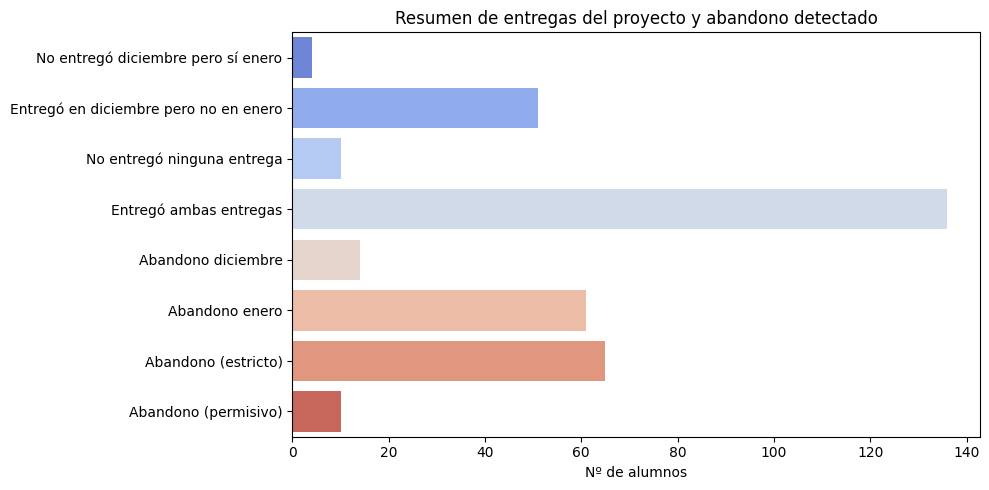

,Condición,Número de alumnos
0,No entregó diciembre pero sí enero,4
1,Entregó en diciembre pero no en enero,51
2,No entregó ninguna entrega,10
3,Entregó ambas entregas,136
4,Abandono diciembre,14
5,Abandono enero,61
6,Abandono (estricto),65
7,Abandono (permisivo),10


In [14]:
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Contar los casos
no_dic_si_ene = df_entregas_combinado.filter((~col("entrego_dic")) & (col("entrego_ene"))).count()
si_dic_no_ene = df_entregas_combinado.filter((col("entrego_dic")) & (~col("entrego_ene"))).count()
ninguna = df_entregas_combinado.filter((~col("entrego_dic")) & (~col("entrego_ene"))).count()
ambas = df_entregas_combinado.filter((col("entrego_dic")) & (col("entrego_ene"))).count()

# Abandono por reglas
abandono_estricto = df_entregas_combinado.filter((~col("entrego_dic")) | (~col("entrego_ene"))).count()
abandono_permisivo = df_entregas_combinado.filter((~col("entrego_dic")) & (~col("entrego_ene"))).count()
abandono_dic = df_entregas_combinado.filter(~col("entrego_dic")).count()
abandono_ene = df_entregas_combinado.filter(~col("entrego_ene")).count()

# Crear resumen como DataFrame de Pandas
resumen = {
    "No entregó diciembre pero sí enero": no_dic_si_ene,
    "Entregó en diciembre pero no en enero": si_dic_no_ene,
    "No entregó ninguna entrega": ninguna,
    "Entregó ambas entregas": ambas,
    "Abandono diciembre": abandono_dic,
    "Abandono enero": abandono_ene,
    "Abandono (estricto)": abandono_estricto,
    "Abandono (permisivo)": abandono_permisivo
}

df_resumen = pd.DataFrame(list(resumen.items()), columns=["Condición", "Número de alumnos"])

# Mostrar gráfico
plt.figure(figsize=(10, 5))
sns.barplot(data=df_resumen, y="Condición", x="Número de alumnos", palette="coolwarm")
plt.title("Resumen de entregas del proyecto y abandono detectado")
plt.xlabel("Nº de alumnos")
plt.ylabel("")
plt.tight_layout()
plt.show()

# Mostrar tabla
df_resumen


## Análisis de los resultados

Analizando la tabla y la gráfica, podemos extraer información muy útil para decidir qué regla de abandono podemos elegir en base a las entregas del proyecto: 

- Es poco frecuente que un alumno no entregara en diciembre pero sí lo hiciera en enero. 
- Sin embargo, muchos alumnos entregaron en diciembre, pero luego no lo hicieron en enero, quizás por que en esta segunda entrega es cuando se realiza el grueso del proyecto, y además se junta con el periodo de exámenes de la facultad, por lo que quizá abandonan la entrega como consecuencia de verse faltos de tiempo y dedicárselo a otras asignaturas.
- **Un abandono total**, no entregar en ninguna de las dos entregas, nos dejaría solo con 10 casos positivos, lo cual conformaría un **5% de la clase**  mientras que un **abandono parcial**, considerándo un abandono no entregar en alguna de las dos o en ambas nos deja 65 casos positivos, lo cual **correspondería a un 32,3%**

Por lo tanto, hay un número mucho mayor de abandonos al considerar la entrega de enero, que no la de diciembre. 

Mientras que quizás considerar el abandono en base a la entrega de diciembre es mas significativo del abandono durante el periodo lectivo de clases, y por tanto, de la evaluación continua, el abandono **en enero puede informar más sobre el rendimiento académico del estudiante** en general, dado que no llegó a poder entregar el proyecto principal de la asignatura al completo. 

Dado que no entregar en cualquiera de las dos tareas, supone un rendimiento académico inferior al de aquellos estudiantes que sí que lo hicieron, quizás sea una buena idea considerar la etiqueta final el abandono estricto, para permitir al modelo detectar patrones en un mayor número de estudiantes con signos de carencias en el rendimiento, y exprimir más los datos con los que contamos, que , al ser una sola asignatura, son limitados. 

Además, de esta forma conseguimos un mejor balance de clases.

## Exportar fichero de etiquetas final

In [20]:
# Exportamos etiquetas de la regla de abandono estricta
df_etiquetas = df_entregas_combinado.withColumn(
    "abandona_por_no_entregar_proyecto",
    (~col("entrego_dic")) | (~col("entrego_ene"))
).drop("entrego_dic", "entrego_ene")

df_etiquetas.show(truncate=False)

df_etiquetas.toPandas().to_csv(os.path.join(ruta_destino, f"etiquetas_abandono_v2.csv"), index=False)


+----------------------------------------------------------------+---------------------------------+
|userid                                                          |abandona_por_no_entregar_proyecto|
+----------------------------------------------------------------+---------------------------------+
|006b0e7bd07cec05e0952cb61c30893f6d30d7962f9efc99d0f041f6fadcc320|false                            |
|00ded60939d4949cc46e46e865b25d3f11756733cf946087710c61eda02729e1|false                            |
|05912200993a87a89df1a6ca9ac3d6493e2c4cc178760d8ee1da41033ac01b3e|false                            |
|073b1d0ee1d3857d50ea87087b25bbc6f5dbdbd2e94bcf52b89c48afa37e8c16|false                            |
|080b2c8b65e9d941f12e62b7d2b9fa22b669f06aeed07df5683fdf93a799204d|true                             |
|091af124e119a447c7f6594fb2f7c4fbb678f669966db01e3f62c26eedb220af|false                            |
|0a2e27fd5eb3547b064f5bcd8a26472c8802e19a5c158b380539e85b42d194d9|true                     